# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
import time
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# NYC Green Taxi File Download and Characteristics

Programatically download data from URL Directly. While ingesting data from URL, it was identified that data is not clean in the URL. Other charachteristics of data also observed in this section:

o Mismatch in column names and underlying data

o Wrong Indexing of Data

o Data is of Taxi trips where file maintains record of trip start/end timing Pickup/DropOff Locations, and underlying expenses during trip (Trip Amount, Distance, Tips, Trip, Tax, etc). 

o Along this notebook we will create few additional columns in the dataframe for our calculations. 



In [0]:
#reading from url option 1
df = pd.read_csv("https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2016-11.csv")
##this gives error as data has two extra cols.. it considers first two col as index

In [4]:
df.head() #reads dataframe data, we can see how header rows are not matching with data

VendorID  ... trip_type
2 2016-11-01 00:39:48  2016-11-01 00:50:48  ...       NaN
  2016-11-01 00:28:30  2016-11-01 00:40:44  ...       NaN
  2016-11-01 00:03:45  2016-11-01 00:13:07  ...       NaN
  2016-11-01 00:45:48  2016-11-01 01:00:43  ...       NaN
  2016-11-01 00:27:21  2016-11-01 00:32:53  ...       NaN

[5 rows x 19 columns]

In [0]:
# option 2
# reading head seperately for col names.. and readind data again with skipping col names
col = pd.read_csv("https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2016-12.csv",nrows=0)
#col dataframe now has only 1st row from data file which contains only header, now we will read the column names and assign those columns names

#reading the data with range of column
num_of_cols = len(col.columns)
df = pd.read_csv("https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2016-12.csv",usecols=range(num_of_cols))
#df dataframe is now modified so our column names and underlying data is correctly structured.

In [6]:
df.head() #now dataframe is correct and we can see headers and underlying data correctly aligned.


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type
0,2,2016-12-01 00:00:54,2016-12-01 00:06:54,N,1,92,192,1,1.29,6.5,0.5,0.5,0.00,0.0,NaN,0.3,7.80,2,1
1,2,2016-12-01 00:52:41,2016-12-01 00:54:51,N,1,92,171,1,0.64,4.0,0.5,0.5,1.06,0.0,NaN,0.3,6.36,1,1
2,2,2016-12-01 00:10:39,2016-12-01 00:14:47,N,1,75,238,2,0.89,5.5,0.5,0.5,1.70,0.0,NaN,0.3,8.50,1,1
3,2,2016-12-01 00:12:16,2016-12-01 00:15:31,N,1,166,151,1,0.66,4.5,0.5,0.5,1.74,0.0,NaN,0.3,7.54,1,1
4,2,2016-12-01 00:29:22,2016-12-01 00:39:51,N,1,166,42,1,2.15,9.5,0.5,0.5,2.16,0.0,NaN,0.3,12.96,1,1


In [7]:
df.describe() #s

,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type
count,1.224158e+06,1.224158e+06,1.224158e+06,1.224158e+06,1.224158e+06,1.224158e+06,1.224158e+06,1.224158e+06,1.224158e+06,1.224158e+06,1.224158e+06,0.0,1.224158e+06,1.224158e+06,1.224158e+06,1.224158e+06
mean,1.799278e+00,1.085079e+00,1.131729e+02,1.290862e+02,1.362447e+00,2.618179e+00,1.159368e+01,3.629562e-01,4.872578e-01,1.128787e+00,9.456725e-02,NaN,2.925184e-01,1.399902e+01,1.534862e+00,1.019722e+00
std,4.005404e-01,5.660195e-01,7.628387e+01,7.723367e+01,1.036924e+00,2.806160e+00,9.793499e+00,3.901575e-01,8.517500e-02,2.216306e+00,8.808537e-01,NaN,5.072935e-02,1.112872e+01,5.240995e-01,1.390438e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,-4.990000e+02,-4.500000e+00,-5.000000e-01,-1.056000e+01,-8.540000e+00,NaN,-3.000000e-01,-4.990000e+02,1.000000e+00,1.000000e+00
25%,2.000000e+00,1.000000e+00,4.900000e+01,6.100000e+01,1.000000e+00,9.800000e-01,6.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,NaN,3.000000e-01,7.800000e+00,1.000000e+00,1.000000e+00
50%,2.000000e+00,1.000000e+00,8.300000e+01,1.290000e+02,1.000000e+00,1.700000e+00,9.000000e+00,5.000000e-01,5.000000e-01,0.000000e+00,0.000000e+00,NaN,3.000000e-01,1.080000e+01,2.000000e+00,1.000000e+00
75%,2.000000e+00,1.000000e+00,1.730000e+02,1.930000e+02,1.000000e+00,3.200000e+00,1.400000e+01,5.000000e-01,5.000000e-01,1.860000e+00,0.000000e+00,NaN,3.000000e-01,1.656000e+01,2.000000e+00,1.000000e+00
max,2.000000e+00,6.000000e+00,2.650000e+02,2.650000e+02,9.000000e+00,1.475000e+02,1.007000e+03,4.500000e+00,5.000000e-01,2.507000e+02,2.979800e+02,NaN,3.000000e-01,1.008300e+03,5.000000e+00,2.000000e+00


#Data Cleansing and Transformations
In this section we are going to perform following activities:

o Identify fill rate for each column and drop any column where no values are populated

o Identify Data Types of all remaining columns and convert data types of required columns

o Generate new columns required for visualization and modeling purposed




In [0]:
#identify what is the fill rate for each column
df.count()

In [0]:
#DROPPING COLUMNS
#after running the count command above  we can see that all columns are completely filled except ehail_fee, we will remove this column from our data frame.
df=df.drop(columns='ehail_fee')


In [0]:
#Now lets see what is our dataframe shape, i.e., we will identify number of rows and total column in our dataframe
df.shape

In [0]:
#DATA TYPES - Identify Data Types of all columns in dataframe and determine if any column need to change
df.dtypes
#Pickup and Droppoff columns are of object data type, for our case we will convert these columns to datetime.

In [0]:
#TRANSFORMING AND ADDING COLUMNS

df['lpep_pickup_datetime']=pd.to_datetime(df['lpep_pickup_datetime']) # Convert pickup object to datetime
df['lpep_dropoff_datetime']=pd.to_datetime(df['lpep_dropoff_datetime']) # Convert dropoff object to datetime
df['pickup_day']=df['lpep_pickup_datetime'].dt.day_name() #Get day name when pickup happened
df['dropoff_day']=df['lpep_dropoff_datetime'].dt.day_name() #Get day name when drop-off happened
df['trip_duration']=(df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime'])/np.timedelta64(1,'s') #Get Trip Duration
df['pickup_hour']=df['lpep_pickup_datetime'].dt.hour #Pickup hour
df['dropoff_hour']=df['lpep_dropoff_datetime'].dt.hour #Pickup hour


#Code to break trip in different day times
def timezone(x):
    if x>=datetime.time(4, 0, 1) and x <=datetime.time(7, 0, 0):
        return 'Early Morning'
    elif x>=datetime.time(7, 0, 1) and x <=datetime.time(10, 0, 0):
        return 'Morning'    
    elif x>=datetime.time(10, 0, 1) and x <=datetime.time(16, 0, 0):
        return 'Daytime'
    elif x>=datetime.time(16, 0, 1) and x <=datetime.time(22, 0, 0):
        return 'Evening'
    elif x>=datetime.time(22, 0, 1) or x <=datetime.time(4, 0, 0):
        return 'Late Night'
    
df['pickup_daypart']=df['lpep_pickup_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )
df['dropoff_daypart']=df['lpep_dropoff_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )

bins=np.array([0,1800,3600,5400,7200,90000])
df['duration_period']=pd.cut(df.trip_duration,bins,labels=["0-5", "5-10", "10-15","15-20",">20"])

In [0]:
df['pickup_day'].value_counts() #This command result shows when most picks are taken, by look of data, most trips are taken on Friday and Saturday

In [0]:
df['dropoff_day'].value_counts()

#Data Visualizations

Following maps were plotted:

o Total Pickup's and dropoff's during each day of week

o Total Pickup's and dropoff's during 24 hour window (morning, evening, etc.)

o Average Tips during a day

o Trip Duration charts

o Trip Distance histogram




In [0]:
#PLOTS OF DATA ON SINGLE VARIABLE
#Plot 1: Showing pickups/dropoffs on each day of the week
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(12,6))
sns.countplot(x='pickup_day',data=df,ax=ax[0])
ax[0].set_title('Total Pickups')
sns.countplot(x='dropoff_day',data=df,ax=ax[1])
ax[1].set_title('Total DropOffs')
plt.tight_layout()

#Plot clearly shows that on Saturday and Friday there is jump in pickups and dropoffs in comparison to rest of the week. 

In [0]:
#Plot 2: Showing Pickups/Dropoff's during a day (Early Morning, Morning, Normal Hours, Eveining, and Late Night ) 
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(12,6))
sns.countplot(x='pickup_daypart',data=df,ax=ax[0])
ax[0].set_title('Total Pickups')
sns.countplot(x='dropoff_daypart',data=df,ax=ax[1])
ax[1].set_title('Total DropOffs')
plt.tight_layout()
# Plot is clearly showing that there is high pickups/dropoffs duing evening hours followed by Daytime hours.

Text(0.5, 1.0, 'Hourly Distributions on Dropoffs')

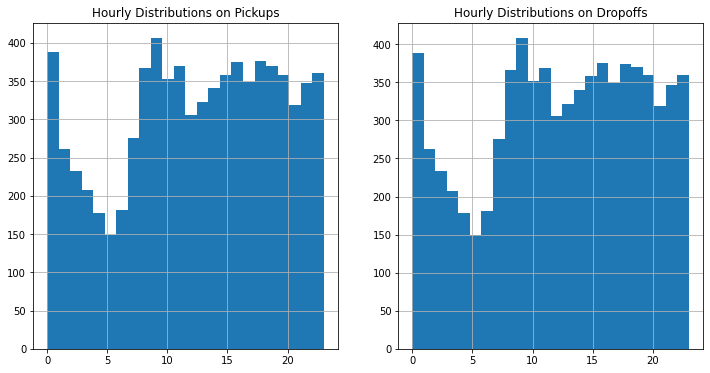

In [140]:
#plot 3: Another representation of pickups and dropoff's during 24 hour window
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(12,6))
df.pickup_hour.hist(bins=24,ax=ax[0])
ax[0].set_title('Hourly Distributions on Pickups')
df.dropoff_hour.hist(bins=24,ax=ax[1])
ax[1].set_title('Hourly Distributions on Dropoffs')

# We can clearly see that more pickup's/dropoff's happens during evening hours

In [0]:
#plot 4: Average Tip Amounts during 24 hour window
sns.catplot(x='pickup_hour',y='tip_amount',kind="bar",data=df,height=6,aspect=1)
plt.title('Average Tip Amount during the day (Pickup)')
sns.catplot(x='dropoff_hour',y='tip_amount',kind="bar",data=df,height=6,aspect=1)
plt.title('Average Tip Amount during the day (Dropoff)')

#Analysis: Although morning hours have higher average tips but looking at plot 1, 2, and 3 we can safely say that mornign hours has lower count of passengers 

In [0]:
#plot 5: Trip durations on day of week
figure,ax=plt.subplots(nrows=1,ncols=3,figsize=(15,5))
ax1=df[(df.duration_period !="< 5")].groupby('pickup_day')['duration_period'].count()
ax1.plot(kind='bar',ax=ax[0])
ax[0].set_title('Distribution of trips > 5 hours')
ax2=df[(df.duration_period !="< 5")].groupby('pickup_day')['duration_period'].value_counts(normalize=True).unstack()
ax2.plot(kind='bar', stacked='True',ax=ax[1])
ax[1].set_title('Percentage distribution of trips')
ax3=df[(df.duration_period !="< 5")].groupby('pickup_day')['duration_period'].value_counts().unstack()
ax3.plot(kind='bar',ax=ax[2])
ax[2].set_title('Distribution of trips')

# Here we can see that longer trips are happening on Saturdays, majority of trips are under 5 hours

In [0]:
#plot 6: Trip Distance to Trip Duration
sns.catplot(x='trip_distance',y='duration_period',kind="bar",data=df,height=6,aspect=1)
plt.title('Trip Distance to Trip Length')

# Longer the distance greater the distance, whereas we can sense there are outliers in >20 result set where results appear to be off.

In [0]:
#plot 7: Trip distance histogram, chart1
plt.figure(figsize=[20,2])
sns.boxplot(df['trip_distance'])

In [0]:
# plot 8: Trip Distance histogram, Chart 2 
sns.distplot(trip_dis) 
sns.distplot(trip_dis[trip_dis <=30.0])


plt.figure(2)
plt.hist(trip_dis[trip_dis <=30.0],bins=20)
plt.title("Trip Distance Histgram")
plt.xlabel("Total Distance")
plt.ylabel("Number of Trips")


#Trip Statistics

Here we did some outlier cleansing and identified median and mean of trips by hour. Plot graph and counts are represented at the end of this section.


In [0]:
print('The value of largest 5 trip duration values are as follows : \n {} '.format(df['trip_duration'].nlargest(5)))
print('The the number of rows with 1 as their trip duration values is {}'.format(len(df[df['trip_duration']==1 ])))


In [0]:
df[df.trip_duration!=df.trip_duration.max()]
df[df.trip_duration!=df.trip_duration.min()]


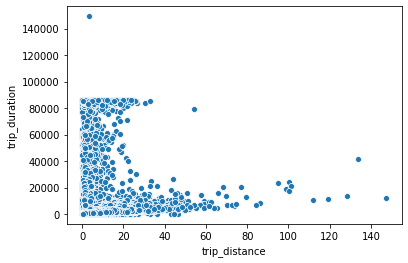

In [131]:
sns.scatterplot(x='trip_distance',y='trip_duration',data=df)

In [106]:
#In graph above we can see there are several outliers which we need to remove from our dataframe
#Lets identify all records where trip_distance is 0
print('The no of rows with distance =0 are {}'.format(len(df[df.trip_distance==0])))

The no of rows with distance =0 are 15183


In [0]:
#instead of dropping these rows we will replace these zero results with average distance
mean_dist=df['trip_distance'].mean()
df.loc[df['trip_distance']==0,'trip_distance']=mean_dist

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


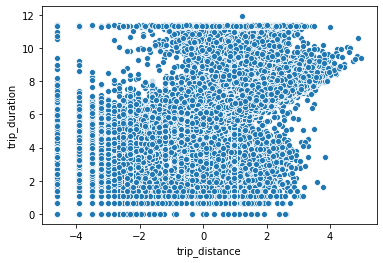

In [136]:
df['trip_distance']=np.log(df.trip_distance)
df['trip_duration']=np.log(df.trip_duration)

sns.scatterplot(x='trip_distance',y='trip_duration',data=df)

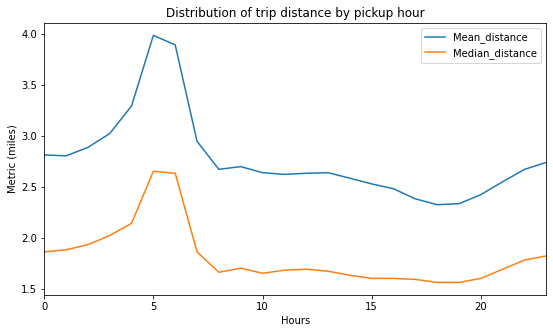

In [146]:
# Mean and Median of trip distance by pickup hour Chart
fig,ax = plt.subplots(1,1,figsize=(9,5)) # prepare fig to plot mean and median values
# use a pivot table to aggregate Trip_distance by hour
table1 = df.pivot_table(index='pickup_hour', values='trip_distance',aggfunc=('mean','median')).reset_index()
# rename columns
table1.columns = ['Hour','Mean_distance','Median_distance']
table1[['Mean_distance','Median_distance']].plot(ax=ax)
plt.ylabel('Metric (miles)')
plt.xlabel('Hours')
plt.title('Distribution of trip distance by pickup hour')
plt.xlim([0,23])
plt.show()
#print '-----Trip distance by hour of the day-----\n'
#print tabulate(table1.values.tolist(),["Hour","Mean_distance","Median_distance"])

In [0]:
table1.describe()


In [0]:
df.groupby('pickup_hour')['tip_amount','total_amount', 'trip_distance'].mean()

#Data Model


In [0]:
df.head()

In [0]:
df.describe()

In [0]:
#Clean your dataframe by leaving only int, float, boolean
df1=df.drop(['lpep_pickup_datetime','store_and_fwd_flag','lpep_dropoff_datetime','pickup_day','dropoff_day','pickup_daypart','dropoff_daypart','duration_period'],axis=1)
df.describe()
df0=df1[df1['trip_type'].notnull() & df1['tip_amount'].notnull()]#remove NaN observations


In [0]:
df0.head()
df0.dtypes #check data types again


In [0]:
#Build the model
#change data the numbers to categorical
factor=['VendorID','RatecodeID','payment_type','passenger_count','trip_type','trip_duration']
for variable in factor:
    dummies = pd.get_dummies(df0[factor], prefix = variable)
    df1= pd.concat([df0, dummies],axis=1)
    df1.drop([variable], axis=1, inplace=True)

Tips= df1['tip_amount']          #only y
df2=df1.drop(['tip_amount'],axis=1) #all the x
X_train,X_test,Y_train,Y_test = train_test_split(df2,Tips,test_size=0.20)


In [192]:
# Check shape
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(979326, 21)
(244832, 21)
(979326,)
(244832,)


In [194]:
#Train your model
gbr=GBR(loss='ls', learning_rate=0.1, n_estimators=100, subsample=1, max_depth =6, verbose =1)
est=gbr.fit(X_train,Y_train)
#prediction experiment
y_test_pred=est.predict(X_test)
mean_squared_error(y_test_pred,Y_test)


      Iter       Train Loss   Remaining Time 
         1           4.1896            5.16m
         2           3.5823            5.02m
         3           3.0857            4.97m
         4           2.6804            4.89m
         5           2.3402            4.84m
         6           2.0619            4.79m
         7           1.8271            4.74m
         8           1.6249            4.68m
         9           1.4571            4.63m
        10           1.3222            4.59m
        20           0.6794            4.38m
        30           0.4691            4.08m
        40           0.3423            3.65m
        50           0.2737            3.14m
        60           0.2271            2.55m
        70           0.1917            1.93m
        80           0.1616            1.30m
        90           0.1408           39.20s
       100           0.1251            0.00s


0.18664933630745656

Text(0.5, 0, 'Iteration')

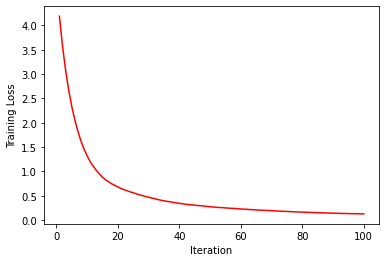

In [195]:
#plot the train loss vs. iteration
n = np.arange(100)+1
plt.plot(n, est.train_score_,'r-')
plt.ylabel('Training Loss')
plt.xlabel('Iteration')

In [0]:
#Lowest mean quare is 0.1866
#Cross-validation and greed search could be used to tune the parameters in the GradientBoostingRegressor model.